In [1]:
from IPython.display import clear_output


import os
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from custom_utils import *
from models import *

import sys
sys.path.insert(1, './stylegan2-ada-pytorch')

import dnnlib
import legacy
from torch_utils import misc

import warnings
warnings.filterwarnings('ignore')

In [52]:
dataset_path = '/projectnb/cs585bp/585-Project-nguymi01/data/'
attr_data = pd.read_csv(os.path.join(dataset_path, 'list_attr_celeba.csv'))

_all_fnames = [
    os.path.relpath(os.path.join(root, fname), start=dataset_path) 
    for root, _dirs, files in os.walk(dataset_path) for fname in files
]
    
_image_fnames = sorted(fname for fname in _all_fnames if os.path.splitext(fname)[-1].lower() == '.jpg')

attr_data = attr_data[attr_data.image_id.isin([elem.split('/')[-1] for elem in _image_fnames])]
labels = (attr_data.values[:, 1:].astype(int) + 1)//2

try:
    with open('overfit_sample_embeddings.npy', 'rb') as f:
        overfit_embeddings = np.load(f)
except FileNotFoundError:
    overfit_embeddings = None

In [54]:
class Projector():
    def __init__(
        self,
        network_pkl = './training-runs/00000--auto1-noaug-resumeffhq256/network-snapshot-000120.pkl',
        *,
        num_steps                  = 1000,
        w_avg_samples              = 10000,
        initial_learning_rate      = .005,
        initial_noise_factor       = 0.05,
        lr_rampdown_length         = 0.25,
        lr_rampup_length           = 0.05,
        noise_ramp_length          = 0.75,
        regularize_noise_weight    = 1e5,
        verbose                    = False,
        device: torch.device
    ):
        
        print(f'Loading networks from "{network_pkl}"...')
        with dnnlib.util.open_url(network_pkl) as fp:
            self.G = legacy.load_network_pkl(fp)['G_ema'].eval().requires_grad_(False).to(device) # type: ignore

        # Load VGG16 feature detector.
        url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
        with dnnlib.util.open_url(url) as f:
            self.vgg16 = torch.jit.load(f).eval().to(device)
                    
        self.num_steps      = num_steps
        self.w_avg_samples  = w_avg_samples
        self.verbose        = verbose
        self.device         = device
        
        self.initial_learning_rate  =initial_learning_rate
        self.initial_noise_factor   =initial_noise_factor
        self.lr_rampdown_length     =lr_rampdown_length
        self.lr_rampup_length       =lr_rampup_length
        self.noise_ramp_length      =noise_ramp_length
        self.regularize_noise_weight=regularize_noise_weight
        
        # Compute w stats.
        self.compute_wstats()
        
    def compute_wstats(self):
        self.logprint(f'Computing W midpoint and stddev using {self.w_avg_samples} samples...')
        z_samples = np.random.RandomState(123).randn(self.w_avg_samples, self.G.z_dim)
        w_samples = self.G.mapping(torch.from_numpy(z_samples).to(self.device), None)  # [N, L, C]
        w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)       # [N, 1, C]
        self.w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 1, C]
        self.w_std = (np.sum((w_samples - self.w_avg) ** 2) / self.w_avg_samples) ** 0.5
        
    def logprint(self, *args):
            if self.verbose:
                print(*args)
    
    def project(
        self,
        target: torch.Tensor, # [C,H,W] and dynamic range [0,255], W & H must match G output resolution
        num_steps  = None,
        w_opt      = None        
    ):
        assert target.shape[1:] == (self.G.img_channels, self.G.img_resolution, self.G.img_resolution)        
        
        if num_steps is None:
            num_steps=self.num_steps
            
        # Features for target image.
        target_images = target.to(torch.float32)
        target_mean = target_images.mean((-1,-2)).view(*target_images.shape[:2], 1,1)
        target_std =  target_images.std((-1,-2)).view(*target_images.shape[:2], 1,1)
        target_normed = (target_images - target_mean) / (target_std + 1e-6)
        target_features = self.vgg16(target_images, resize_images=False, return_lpips=True)

        if w_opt is None:
            n=target_images.shape[0]
            w_opt = torch.tensor(self.w_avg.repeat(n).reshape(self.G.w_dim,1,n).T,
                                 dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable
            
        else:
            w_opt = torch.tensor(
                w_opt.copy()[:, np.newaxis, :],
                dtype=torch.float32, device=device, requires_grad=True)
        
        # Setup noise inputs.
        noise_bufs = { name: buf for (name, buf) in self.G.synthesis.named_buffers() if 'noise_const' in name }
        
        optimizer = torch.optim.AdamW([w_opt] + list(noise_bufs.values()),
                                      betas=(0.9, 0.999), lr=self.initial_learning_rate)

        # Init noise.
        for buf in noise_bufs.values():
            buf.requires_grad = False
            buf[:] = torch.randn_like(buf)
            buf.requires_grad = True

        for step in tqdm(range(num_steps)):
            clear_output(wait=True)

            # Learning rate schedule.
            t = step / num_steps
            w_noise_scale = self.w_std * self.initial_noise_factor * max(0.0, 1.0 - t / self.noise_ramp_length) ** 2
            lr_ramp = min(1.0, (1.0 - t) / self.lr_rampdown_length)
            lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
            lr_ramp = lr_ramp * min(1.0, t / self.lr_rampup_length)
            lr = self.initial_learning_rate * lr_ramp
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

            # Synth images from opt_w.
            w_noise = torch.randn_like(w_opt) * w_noise_scale
            ws = (w_opt + w_noise).repeat([1, self.G.mapping.num_ws, 1])
            synth_images = self.G.synthesis(ws, noise_mode='const')
            synth_images = (synth_images + 1) * (255/2)

            # Features for synth images.
            synth_features = self.vgg16(synth_images, resize_images=False, return_lpips=True)
            dist = 0
            dist+= nn.functional.mse_loss(synth_features, target_features) * target_features.shape[-1]
            dist+= 1-nn.functional.cosine_similarity(target_features, synth_features).mean()
            
            synth_normed = (synth_images - target_mean) / (target_std + 1e-6)
            
            dist+= nn.functional.l1_loss(synth_normed, target_normed)

            # Noise regularization.
            reg_loss = 0.0
            for v in noise_bufs.values():
                noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
                while True:
                    reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                    reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                    if noise.shape[2] <= 8:
                        break
                    noise = F.avg_pool2d(noise, kernel_size=2)
            loss = dist + reg_loss * self.regularize_noise_weight

            # Step
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_value_([w_opt] + list(noise_bufs.values()), clip_value=1e-1)
            optimizer.step()
            logstr=f'step {step+1:>4d}/{num_steps}: dist {dist:<4.4f} loss {float(loss):<5.4f}'
            self.logprint(logstr)

            # Save projected W for each optimization step.
            
            # Normalize noise.
            with torch.no_grad():
                for buf in noise_bufs.values():
                    buf -= buf.mean()
                    buf *= buf.square().mean().rsqrt()

        return w_opt, logstr


In [55]:
device=torch.device('cuda')
network_pkl = './training-runs/00001--auto1-noaug-resumecustom/network-snapshot-000120.pkl'

projector = Projector(
    network_pkl=network_pkl,
    device=device,
    num_steps=512
)

Loading networks from "./training-runs/00001--auto1-noaug-resumecustom/network-snapshot-000120.pkl"...


In [72]:
ws = []

In [73]:
batch_size=8
batch_num = 0

In [ ]:
for batch_num in tqdm(range(batch_num, 1 + overfit_embeddings.shape[0] // batch_size)):

    target_images = load_image_batch(_image_fnames, dataset_path=dataset_path,
                                     batch_size=batch_size, batch_num=batch_num)
    target_images = torch.tensor(target_images.transpose([0,3,1,2]), device=device, requires_grad=False) # pylint: disable=not-callable
    w_opt = None
    if overfit_embeddings is not None and overfit_embeddings.shape[0] > batch_size*(batch_num+1):
        w_opt = overfit_embeddings[batch_size*batch_num:batch_size*(batch_num+1)]

    _ws, logstr = projector.project(
        target=target_images,
        w_opt=w_opt
    )
    _ws = _ws.cpu().detach().numpy().squeeze()
    print(logstr)
    synth_images = synthesize_images(projector.G, _ws.squeeze(), device=torch.device('cuda'))
    show_image_ongrid(synth_images.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().detach().numpy())
    
    ws.append(_ws)

    with open('overfit_sample_embeddings_freshrun.npy', 'wb') as f:
        np.save(f, np.vstack(ws))

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


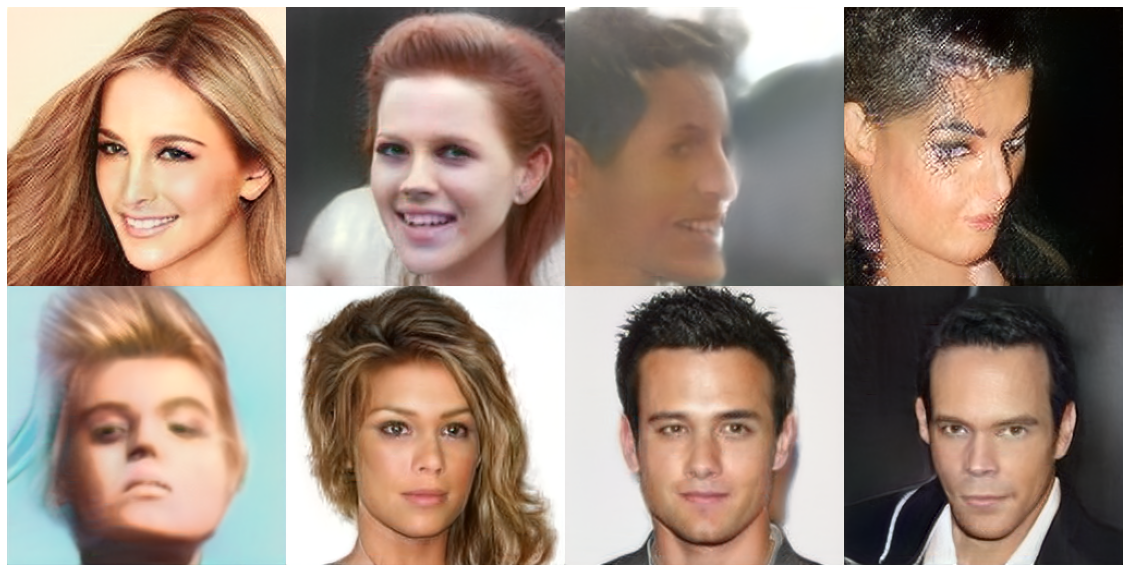

In [77]:
synth_images = synthesize_images(projector.G, ws[0].squeeze(), device=torch.device('cuda'))
show_image_ongrid(synth_images.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().detach().numpy())